In [1]:
import numpy as np
import pandas as pd
import scipy.stats as sc
from bronx.stdtypes.date import daterangex as rangex
from results_v2 import *
from data_v2 import *
import warnings
from scipy.interpolate import griddata, LinearNDInterpolator

warnings.filterwarnings("ignore")

In [2]:
data_train_location = '/cnrm/recyf/Data/users/danjoul/dataset/data_train/'
data_valid_location = '/cnrm/recyf/Data/users/danjoul/dataset/data_test/'
data_test_location = '/cnrm/recyf/Data/users/danjoul/dataset/data_test/'
data_static_location = '/cnrm/recyf/Data/users/danjoul/dataset/'
baseline_location = '/cnrm/recyf/Data/users/danjoul/dataset/baseline/test/'


'''
Setup
'''
working_dir = '/cnrm/recyf/Data/users/danjoul/unet_experiments/params/tests/'


In [3]:
X_500m = np.load(data_test_location + 'G9L1_2021-07-01T00:00:00Z_t2m.npy').transpose([2, 0, 1])
X_r    = np.load(data_test_location + 'oper_r_2021-07-01T00:00:00Z_t2m.npy').transpose([2, 0, 1])
X_c    = np.load(data_test_location + 'oper_c_2021-07-01T00:00:00Z_t2m.npy').transpose([2, 0, 1])

In [4]:
X_500m = X_500m.reshape(X_500m.shape[0], 1, X_500m.shape[1], X_500m.shape[2])
X_r    = X_r.reshape(X_r.shape[0], 1, X_r.shape[1], X_r.shape[2])
X_c    = X_c.reshape(X_c.shape[0], 1, X_c.shape[1], X_c.shape[2])
X_500m.shape

(11, 1, 214, 267)

In [5]:
psd_500m = PowerSpectralDensity(X_500m)
psd_r    = PowerSpectralDensity(X_r)
psd_c    = PowerSpectralDensity(X_c)
psd_500m.shape

(1, 103)

In [6]:
psd_500m = psd_500m[0, :]
psd_r    = psd_r[0, :]
psd_c    = psd_c[0, :]
psd_c.shape

(20,)

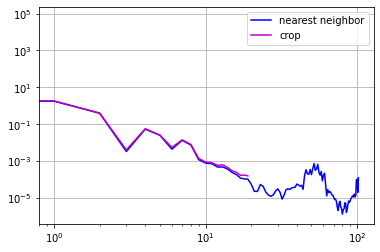

In [66]:
fig, ax = plt.subplots()
# ax.plot(psd_500m, color='r', label='y_test')
ax.plot(psd_r, color='b', label='nearest neighbor')
ax.plot(psd_c, color='m', label='crop')
ax.legend()
ax.grid()
ax.loglog()
fig.savefig('PSD.png')

[]

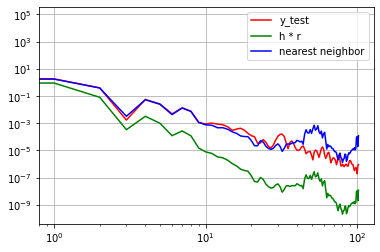

In [67]:
h = 1/(1 + np.linspace(0, 100, 103)**2)

fig, ax = plt.subplots()
ax.plot(psd_500m, color='r', label='y_test')
ax.plot(psd_r * h, color='g', label='h * r')
ax.plot(psd_r, color='b', label='nearest neighbor')
ax.legend()
ax.grid()
ax.loglog()

In [84]:
X_c.shape

(11, 1, 42, 53)

In [124]:
px, py = [], []
for i in range(42):
    for j in range(53):
        px.append(i*5)
        py.append(j*5)
values = X_c[0, 0, :, :].reshape(-1)
x, y = np.mgrid[0:5*41, 0:5*52]
X_bl = griddata((px, py), values, (x, y), method='linear')


In [125]:
X_bl.shape

(205, 260)

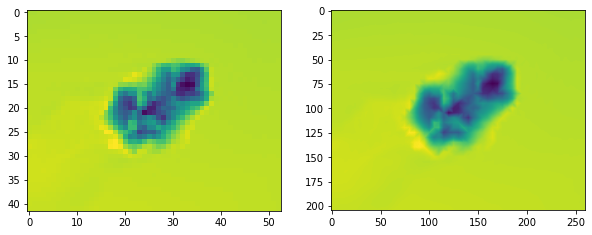

In [126]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
im = axs[0].imshow(X_c[0, 0, :, :])
im = axs[1].imshow(X_bl[:, :])

In [127]:
count = 0
for i in range(X_bl.shape[0]):
    for j in range(X_bl.shape[1]):
        if np.isnan(X_bl[i, j]):
            print('Oulala!')
            count += 1

count

0

In [144]:
px, py = [], []
for i in range(42):
    for j in range(53):
        px.append(i*5)
        py.append(j*5)
x, y = np.mgrid[0:5*41, 0:5*52]

X_bl = np.zeros((X_c.shape[0], 1, x.shape[0], y.shape[1]))
X_bc = np.zeros((X_c.shape[0], 1, x.shape[0], y.shape[1]))
X_nn = np.zeros((X_c.shape[0], 1, x.shape[0], y.shape[1]))

for k in range(X_c.shape[0]):
    values_k = X_c[k, 0, :, :].reshape(-1)
    X_nn_k = griddata((px, py), values, (x, y), method='nearest')
    X_bl_k = griddata((px, py), values, (x, y), method='linear')
    X_bc_k = griddata((px, py), values, (x, y), method='cubic')
    X_nn[k, 0, :, :] = X_nn_k
    X_bl[k, 0, :, :] = X_bl_k
    X_bc[k, 0, :, :] = X_bc_k
X_bc.shape

(11, 1, 205, 260)

In [145]:
psd_nn = PowerSpectralDensity(X_nn)[0, :]
psd_bl = PowerSpectralDensity(X_bl)[0, :]
psd_bc = PowerSpectralDensity(X_bc)[0, :]
psd_nn.shape

(101,)

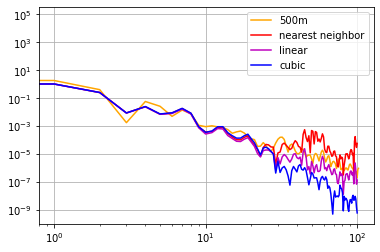

In [155]:
fig, ax = plt.subplots()
ax.plot(psd_500m, color='orange', label='500m')
ax.plot(psd_nn, color='red', label='nearest neighbor')
ax.plot(psd_bl, color='m', label='linear')
ax.plot(psd_bc, color='blue', label='cubic')
# ax.plot(psd_nn, color='b', label='nn')
ax.legend()
ax.grid()
ax.loglog()
fig.savefig('PSDs.png')